In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.io import load_objs_as_meshes

torch.set_grad_enabled(False)

device = "cuda"
mesh_path = "data/meshes/mixamo-human.obj"

# read mesh
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)
mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

# Setup Texturing Views

In [2]:
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_vid
from pytorch3d.renderer import FoVPerspectiveCameras

n_frames = 5
angles = torch.linspace(-20, 20, n_frames)
angles = [0, 45, 135, 180, 225, 315]
elevs = [20, 50, -50]


all_angles = angles * len(elevs)
all_elevs = torch.cat([torch.Tensor([e] * len(angles)) for e in elevs])

R, T = turntable_extrinsics(dists=1.5, angles=all_angles, elevs=all_elevs)
view_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=40)
view_meshes = mesh.extend(len(view_cams))

depths = render_depth_map(view_meshes, view_cams)
display_vid(pil_frames_to_clip(depths))

In [3]:
from text3d2video.utilities.camera_placement import cam_view_prompt

prompt_views = []
for a, e in zip(all_angles, all_elevs):
    suffix = cam_view_prompt(a, e)
    prompt_views.append(suffix)

# Texturing

In [4]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline
from diffusers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
texturing_pipe = load_pipeline(
    TexturingPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [42]:
from text3d2video.noise_initialization import UVNoiseInitializer
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.sd_feature_extraction import AttnType, BlockType, find_attn_layers

sa_up_layers = find_attn_layers(
    texturing_pipe.unet,
    block_types=[BlockType.MID, BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
)

cfg = TexturingConfig(
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=sa_up_layers,
)

prompt = "Stormtrooper"
prompts = [f"{prompt}, {view} view" for view in prompt_views]
print(prompts)

['Stormtrooper, front view', 'Stormtrooper, front view', 'Stormtrooper, back view', 'Stormtrooper, back view', 'Stormtrooper, back view', 'Stormtrooper, front view', 'Stormtrooper, front view', 'Stormtrooper, front view', 'Stormtrooper, back view', 'Stormtrooper, back view', 'Stormtrooper, back view', 'Stormtrooper, front view', 'Stormtrooper, front view', 'Stormtrooper, front view', 'Stormtrooper, back view', 'Stormtrooper, back view', 'Stormtrooper, back view', 'Stormtrooper, front view']


In [46]:
noise_initializer = UVNoiseInitializer()

generator = torch.Generator(device="cuda")
generator.manual_seed(1)

video_frames = texturing_pipe(
    prompts,
    view_meshes,
    view_cams,
    verts_uvs,
    faces_uvs,
    conf=cfg,
    generator=generator,
)

100%|██████████| 15/15 [01:11<00:00,  4.75s/it]


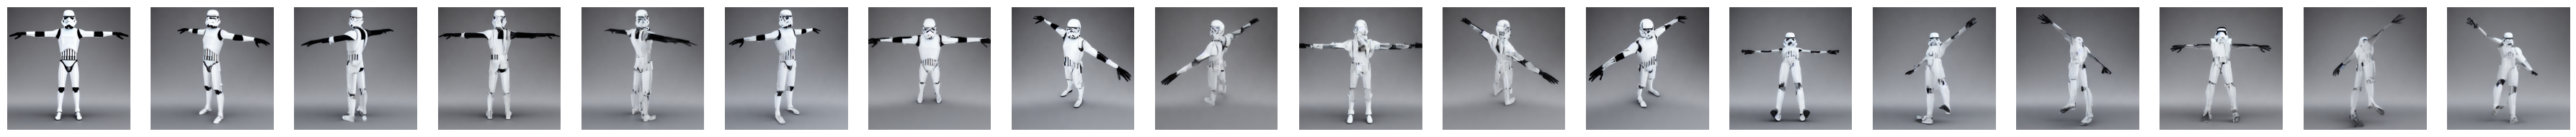

In [47]:
from text3d2video.utilities.ipython_utils import display_ims

display_ims(video_frames)

In [48]:
display_vid(pil_frames_to_clip(video_frames))

In [49]:
import os
from pathlib import Path

from text3d2video.utilities.logging import H5Logger

logged_features = H5Logger(Path("features.h5"))
logged_features.open_read()
_ = os.system("du -h features.h5")

6,7G	features.h5


In [50]:
logged_features.value_names()

['bg_noise', 'kvs_cond', 'kvs_uncond', 'tex_cond', 'tex_uncond', 'uv_noise']

In [51]:
name = "kvs_cond"

ts = logged_features.get_key_values(name, "t")
layers = logged_features.get_key_values(name, "layer")

t = ts[0]
layer = layers[0]

kvs = logged_features.read(name, t=t, layer=layer, return_pt=True)
kvs.shape

torch.Size([256, 1280])

# Feature Injection Pipeline

In [52]:
from text3d2video.pipelines.rd_2_pipeline import ReposableDiffusion2Pipeline

pipe_injection = load_pipeline(
    ReposableDiffusion2Pipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   4 of 4 files downloaded.  


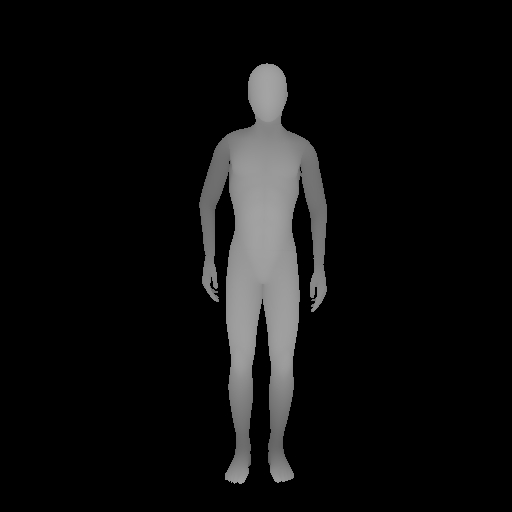

In [69]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("joyful_jump:latest")
# anim = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")

indices = anim.frame_indices(20)
cams, meshes = anim.load_frames(indices)
anim_verts_uvs, anim_faces_uvs = anim.uv_data()

depths = render_depth_map(meshes, cams)
depths[0]

In [55]:
# Use texturing views
cams = view_cams
meshes = view_meshes
anim_verts_uvs = verts_uvs
anim_faces_uvs = faces_uvs

In [72]:
from text3d2video.pipelines.rd_2_pipeline import FeatureInjectionConfig
from text3d2video.utilities.logging import GrLogger

rd_config = FeatureInjectionConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    chunk_size=5,
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1,
    module_paths=sa_up_layers,
    time_threshold=0.8,
    layer_threshold=1.0,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(2)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=10)
logger.delete_data()
logger.open_write()

frames_injection = pipe_injection(
    'Stormtrooper Back View',
    meshes,
    cams,
    anim_verts_uvs,
    anim_faces_uvs,
    rd_config,
    logged_features,
    generator=generator,
    logger=logger,
)

# display_ims(frames_injection, scale=10)

100%|██████████| 15/15 [00:42<00:00,  2.86s/it]


In [73]:
display_vid(pil_frames_to_clip(frames_injection))

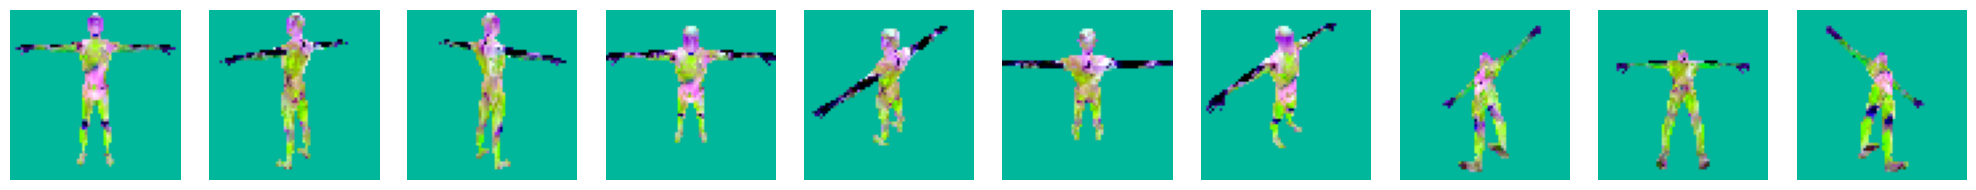

In [58]:
from einops import rearrange

from text3d2video.feature_visualization import RgbPcaUtil


name = "rendered_cond"

frame_indices = logger.get_key_values(name, "frame_i")
ts = logger.get_key_values(name, "t")
layers = logger.get_key_values(name, "layer")

t = ts[0]
layer = layers[5]

rendered = [
    logger.read(name, t=t, layer=layer, frame_i=i, return_pt=True)
    for i in frame_indices
]
rendered = torch.stack(rendered)

pca_features = rearrange(rendered[0], "c h w -> (h w) c")
pca = RgbPcaUtil.init_from_features(pca_features)
rendered_ims = [pca.feature_map_to_rgb_pil(f) for f in rendered]
display_ims(rendered_ims)

# Rendering Texture

In [18]:
from text3d2video.backprojection import project_visible_texels_to_camera

uv_res = 1000
texel_xys = []
texel_uvs = []
for cams, view_mesh in zip(view_cams, view_meshes):
    projection = project_visible_texels_to_camera(
        view_mesh, cams, verts_uvs, faces_uvs, uv_res, raster_res=3000
    )
    texel_xys.append(projection.xys)
    texel_uvs.append(projection.uvs)

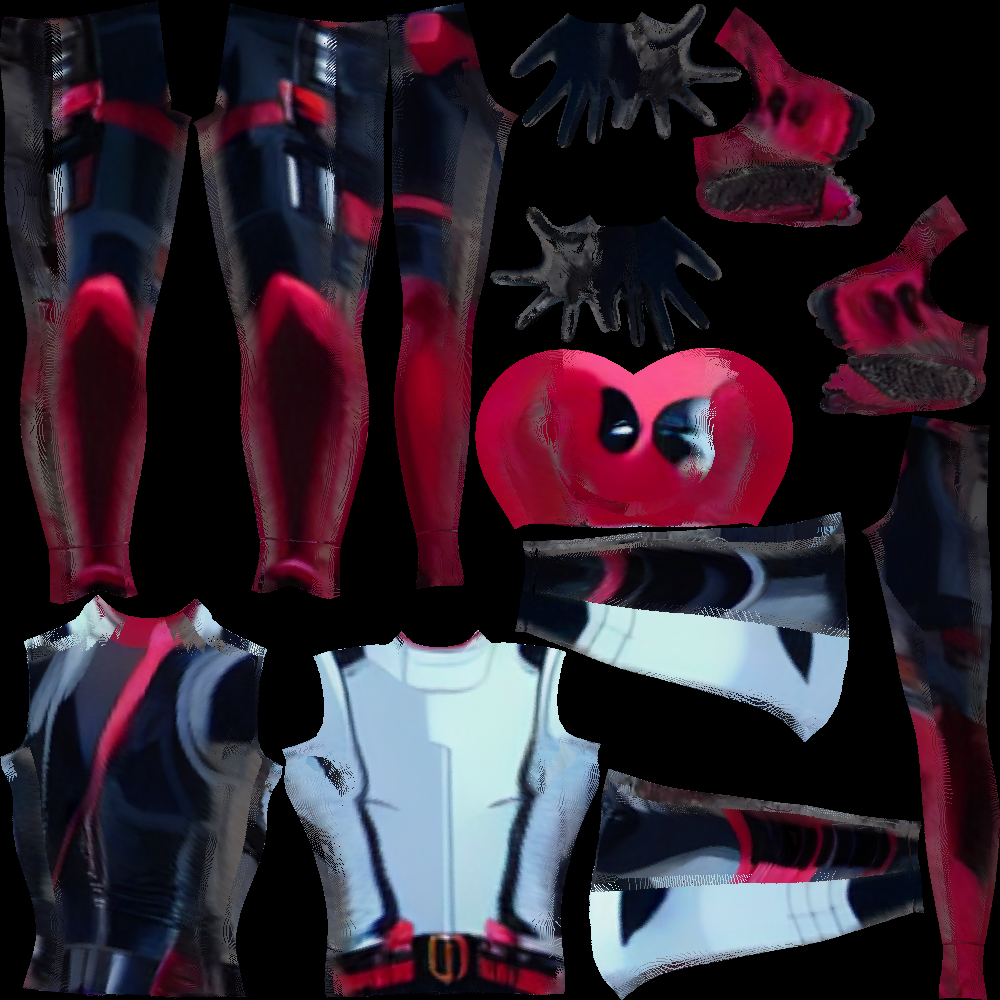

In [19]:
from text3d2video.backprojection import aggregate_views_uv_texture
import torchvision.transforms.functional as TF

texture_ims = [TF.to_tensor(x) for x in video_frames]
texture_ims = torch.stack(texture_ims).to(device)
uv_map = aggregate_views_uv_texture(
    texture_ims, uv_res, texel_xys, texel_uvs, interpolation_mode="bilinear"
)

TF.to_pil_image(uv_map.permute(2, 0, 1))

In [20]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import make_mesh_renderer, make_repeated_uv_texture

renderer = make_mesh_renderer()

anim = AnimationArtifact.from_wandb_artifact_tag("mma:latest")
indices = anim.frame_indices(20)
cams, mesh = anim.load_frames(indices)
vid_verts_uvs, vid_faces_uvs = anim.uv_data()

mesh.textures = make_repeated_uv_texture(
    uv_map, vid_faces_uvs, vid_verts_uvs, N=len(cams)
)

renders = renderer(mesh, cameras=cams)
renders_pil = [TF.to_pil_image(r) for r in renders]
display_vid(pil_frames_to_clip(renders_pil))